In [39]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import  mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import calendar
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import itertools
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING) # silence training info

# Preparing the Data

### Read Data

In [40]:
data_path = '../Data/Electric_Consumption.csv'
df=pd.read_csv(data_path)

print(df.shape)
df.head()

(521035, 27)


,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

In [44]:
# convert to datetime and rename columns
df['Service Start Date'] = pd.to_datetime(df['Service Start Date'])
df['ds'] = pd.to_datetime(df['Service End Date'])
df['y'] = df['Consumption (KWH)']

# set Date as index
df.set_index('ds', inplace=True)
df_ts = df[['y']].copy()

## Resampling - Monthly and Yearly

In [45]:
# resampling to monthly end date
df_monthly = df_ts.resample('ME').mean()
df_monthly = df_monthly[:-1] # remove last month (January 2025, which has no data)
df_monthly.index.freq = pd.infer_freq(df_monthly.index)
df_monthly = df_monthly.reset_index()
df_monthly.head()

,ds,y
0,2010-01-31,45446.030782
1,2010-02-28,38824.279283
2,2010-03-31,36652.063380
3,2010-04-30,36823.726747
4,2010-05-31,36918.425453


In [46]:
# resampling to yearly end date
df_yearly = df_ts.resample('YE').mean()
df_yearly = df_yearly[:-1] # remove last month (2025, which has no data)
df_yearly.index.freq = pd.infer_freq(df_yearly.index)
df_yearly = df_yearly.reset_index()
df_yearly.head()

,ds,y
0,2010-12-31,44608.503400
1,2011-12-31,150980.000000
2,2012-12-31,36346.207317
3,2013-12-31,32702.755515
4,2014-12-31,30694.267709


In [47]:
# save monthly and yearly data
df_monthly.to_csv('../Data/df_monthly.csv')
df_yearly.to_csv('../Data/df_yearly.csv')

# EDA

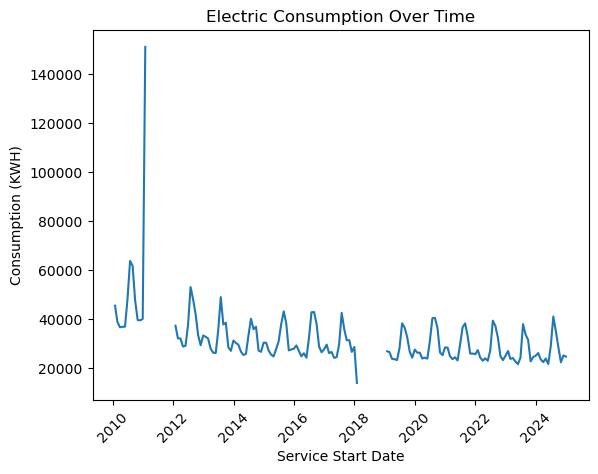

In [48]:
plt.ylabel('Consumption (KWH)')
plt.xlabel('Service Start Date')
plt.title('Electric Consumption Over Time')
plt.plot(df_monthly['ds'], df_monthly['y'])
plt.xticks(rotation=45)
plt.show()

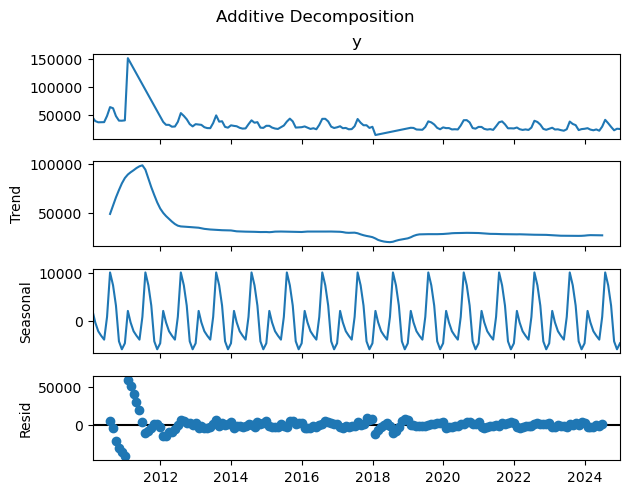

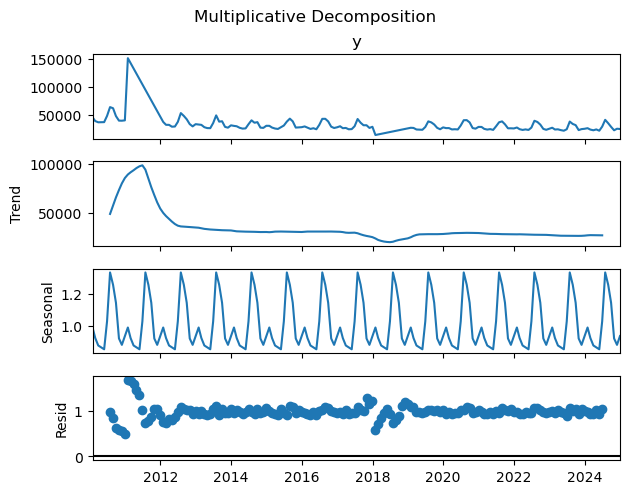

In [49]:
# ensure datetime index
df_monthly = df_monthly.set_index('ds')

# for visualization purposes, we use time interpolation for missing values
df_monthly['y'] = df_monthly['y'].interpolate(method='time') 

# additive decomposition
result_add = seasonal_decompose(df_monthly['y'], model='additive', period=12)
result_add.plot()
plt.suptitle("Additive Decomposition", y=1.02)
plt.show()

# multiplicative decomposition
result_mult = seasonal_decompose(df_monthly['y'], model='multiplicative', period=12)
result_mult.plot()
plt.suptitle("Multiplicative Decomposition", y=1.02)
plt.show()


* Additive decomppsition fits the data more, as the the magnitude of seasonality and trend components remain constant over time.
* The additive decomposition catches the residuals better (closer to 0) than the multiplicative decomposition.

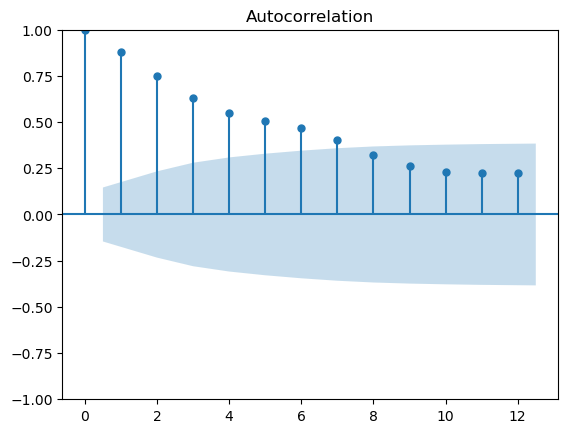

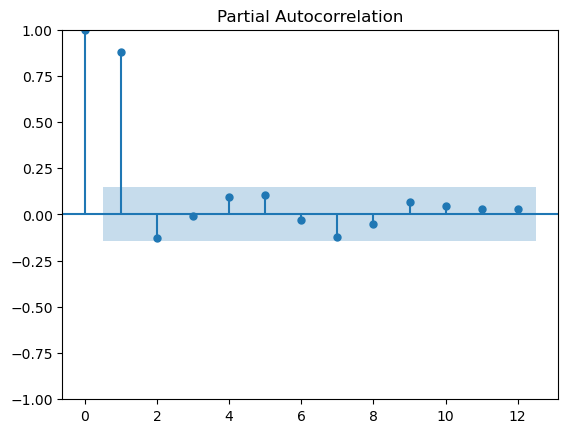

In [50]:
# plot ACF and PACF
plot_acf(df_monthly['y'].dropna(), lags=12)
plt.title("Autocorrelation")
plt.show()

plot_pacf(df_monthly['y'].dropna(), lags=12)
plt.title("Partial Autocorrelation")
plt.show()


#### Notes:
1. **ACF** - our time series has long-term dependencies, meaning the value at any given point is somewhat influenced by previous values. The gradual decline indicates a strong correlation at lower lags and a weak correlation at higher lags. This type of behavior could be indicative of a trend in the series that decays over time.

2. **PACF** - PACF helps identify the direct correlation between a time series value and its past values, removing the indirect effects of intervening lags.
    * This is typical AR(1) process. The PACF cuts off after lag 1, meaning we likely only need 1 autoregressive term in models like ARIMA/SARIMA.
    * The absence of significant peaks after lag 1 implies there is no further direct correlation between the time series and values further back in time, suggesting that only the immediate past values influence the current one.

In [51]:
result = adfuller(df_monthly['y'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("Series is likely stationary")
else:
    print("Series is likely non-stationary")

ADF Statistic: -3.504478527058231
p-value: 0.007872818190116324
Series is likely stationary


The Augmented Dickey–Fuller (ADF) test is used to check whether a time series is stationary (i.e., its properties like mean and variance don’t change over time).
* **ADF Statistic** -	A very negative value (-3.5) provides evidence against the null hypothesis (which assumes non-stationarity).
* **p-value = 0.0079** -Since it's < 0.05, we reject the null hypothesis and say that the data is statistically stationary.

<Axes: title={'center': 'Monthly Consumption Trends by Year'}, xlabel='month'>

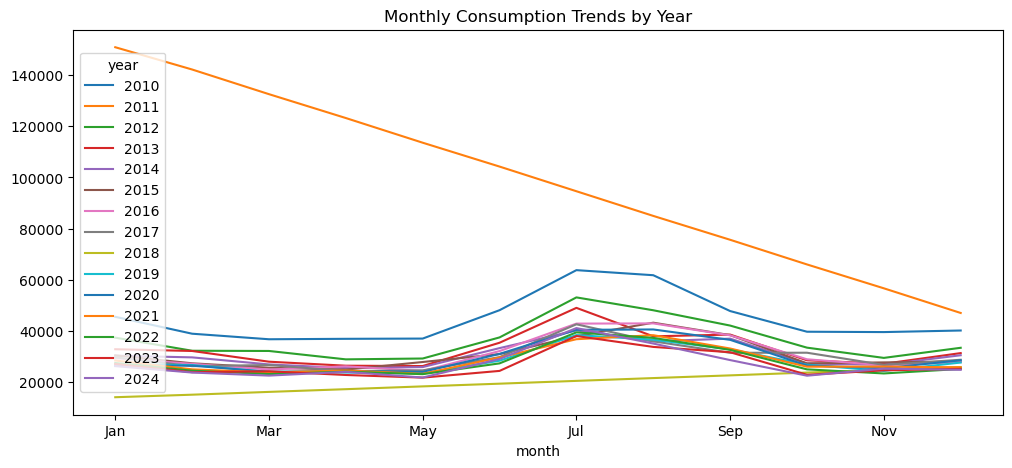

In [52]:
# Create a copy of the monthly data
seaonality_plot_df = df_monthly.copy()

# Extract the year and month from the datetime index
seaonality_plot_df['year'] = df_monthly.index.year
seaonality_plot_df['month'] = df_monthly.index.month

# Pivot the data to have months as rows and years as columns
pivot = seaonality_plot_df.pivot_table(index='month', columns='year', values='y')

# Rename month index to short names (e.g., JAN, FEB, MAR, ...)
pivot.index = pivot.index.map(lambda x: calendar.month_abbr[x])

# Plot the data
pivot.plot(figsize=(12, 5), title='Monthly Consumption Trends by Year')


# Optimization - Grid Search Approach

Process:
1. Infer frequency of dataframe.
2. Tune Prophet using "Gridsearch" approach.
3. Fit Prophet model with best parameters from tuning.
4. Plot results.
5. Display comparison table.

## Helper Functions

In [53]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    """
    computes common regression metrics (mae, mape, r2) between true and predicted values.

    parameters:
    y_true (np.ndarray): array of true values.
    y_pred (np.ndarray): array of predicted values.

    returns:
    tuple: mae, mape, and r2 score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mape, r2

In [63]:
def tune_model(df: pd.DataFrame, param_grid: dict, freq:'str') -> pd.DataFrame:
    """
    tunes the Prophet model for yearly data.

    parameters:
    df (pd.DataFrame): dataframe with yearly frequency.

    returns:
    pd.DataFrame: tuning results.
    """
    results = []
    cap_value = df['y'].max() * 1.1

    param_grid = list(itertools.product(*param_grid.values()))

    if freq == 'ME':
        train = df[(df['ds'] >= '2012-01-01') & (df['ds'] <= '2017-12-31')].copy()
        test = df[(df['ds'] >= '2019-01-01') & (df['ds'] <= '2024-12-31')].copy()
    else: # freq == 'YE
        train = df[df['ds'] <= '2020-12-31'].copy()
        test = df[(df['ds'] > '2020-12-31') &(df['ds'] <= '2024-12-31')].copy()

    for growth, n_changepoints, cps, period, fourier in tqdm(param_grid, desc="Tuning Monthly Prophet"):
        df_train = train.copy()
        if growth == 'logistic':
            df_train['cap'] = cap_value

        model = Prophet(growth=growth, n_changepoints=n_changepoints, changepoint_prior_scale=cps)
        model.add_seasonality(name='custom', period=period, fourier_order=fourier)

        try:
            model.fit(df_train)
            df_test_future = test[['ds']].copy()
            if growth == 'logistic':
                df_test_future['cap'] = cap_value

            forecast = model.predict(df_test_future)
            y_true = test['y'].values
            y_pred = forecast['yhat'].values

            mae, mape, r2 = compute_metrics(y_true, y_pred)

            results.append({
                'params': {
                    'growth': growth,
                    'n_changepoints': n_changepoints,
                    'changepoint_prior_scale': cps,
                    'period': period,
                    'fourier_order': fourier
                },
                'mae': mae,
                'mape': mape,
                'r2': r2
            })
        except Exception:
            continue

    return pd.DataFrame(results).sort_values(by=['mae', 'mape', 'r2'], ascending=[True, True, False])

In [ ]:
def tune_prophet_model(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    """
    delegates prophet model tuning based on frequency.
    
    parameters:
    df (pd.DataFrame): dataframe containing the time series data.
    freq (str): frequency of the time series data.
    
    returns:
    pd.DataFrame: dataframe containing the results of the grid search.
    """
    if freq == 'ME':
        param_grid = {
        'growth_options' : ['linear', 'logistic', 'flat'],
        'n_changepoints_options' : [10, 25, 50],
        'changepoint_prior_scale_options' : [0.01, 0.1, 0.5],
        'seasonality_periods' : [6, 12],
        'seasonality_orders' : [5, 10, 15]}
    else:
        param_grid = {
        'growth_options' : ['linear', 'logistic', 'flat'],
        'n_changepoints_options' : [1, 3, 5],
        'changepoint_prior_scale_options' : [0.05, 0.01, 0.05, 0.1],
        'seasonality_periods' : [None, 1, 2],
        'seasonality_orders' : [2, 4, 10]}


    return tune_model(df, param_grid, freq)

In [ ]:
def train_final_model(df: pd.DataFrame, best_params: dict, freq: str) -> tuple:
    """
    trains the final prophet model using the best parameters from the grid search 
    and returns the trained model and forecasts for 20 years or 9 months.

    parameters:
    df (pd.DataFrame): dataframe containing the monthly time series data.
    best_params (dict): dictionary containing the best parameters for the prophet model.

    returns:
    tuple: trained model and forecast dataframe.
    """
    cap_value = df['y'].max() * 1.1  # 10% higher than max value
    df_full = df.copy()
    if best_params['growth'] == 'logistic':
        df_full['cap'] = cap_value

    # create the final model with the best parameters
    model = Prophet(
        growth=best_params['growth'],
        n_changepoints=best_params['n_changepoints'],
        changepoint_prior_scale=best_params['changepoint_prior_scale'],

    )
    model.add_seasonality(name='custom', period=best_params['period'], fourier_order=best_params['fourier_order'])
    model.fit(df_full)

    # forecast horizon logic
    forecast_horizon = 20 if freq == 'YE-DEC' else 9  # 20 years for yearly, 9 months for monthly
    future = model.make_future_dataframe(periods=forecast_horizon, freq=freq)  # adjust forecast horizon
    if best_params['growth'] == 'logistic':
        future['cap'] = cap_value

    forecast = model.predict(future)
    return model, forecast


In [68]:
def plot_forecast(df: pd.DataFrame, forecast: pd.DataFrame, freq: str) -> None:
    """
    Plots the forecasted data.
    
    parameters:
    df (pd.DataFrame): dataframe containing the original data.
    forecast (pd.DataFrame): dataframe containing the forecasted data.
    freq (str): frequency of the time series data.
    """
    plt.figure(figsize=(15, 6))

    # ensure datetime format without timezone issues
    df['ds'] = pd.to_datetime(df['ds'])
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # determine the start and end dates of the training and test periods
    if freq == 'ME':
        train_start = pd.to_datetime("2012-01-31")  # start of training for monthly data
        train_end = pd.to_datetime("2017-12-31")
        test_start = pd.to_datetime("2019-01-01")
        horizon_splits = [1, 6, 9]  # 1-month, 2–6, 7–9
    elif freq == 'YE-DEC':
        train_start = pd.to_datetime("2010-01-01")  # start of training for yearly data
        train_end = pd.to_datetime("2020-12-31")
        test_start = pd.to_datetime("2021-01-01")
        horizon_splits = [1, 10, 20]  # 1-year, 2–10, 11–20
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    train = df[(df['ds'] >= train_start) & (df['ds'] <= train_end)]  # use dynamic train start date
    test = df[(df['ds'] >= test_start) & (df['ds'] <= df['ds'].max())]

    # dynamically determine the cutoff date from the last actual observation
    cutoff_date = df['ds'].max()
    forecast_period = forecast[forecast['ds'] > cutoff_date].copy()

    # plot main series
    forecast = forecast[forecast['ds'] >= train_start]
    plt.plot(train['ds'], train['y'], label='Train', color='blue')
    plt.plot(test['ds'], test['y'], label='Test', color='orange')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prediction', color='black')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

    # plot forecast horizon coloring
    horizon_len = len(forecast_period)
    if freq == 'ME' and horizon_len >= horizon_splits[-1]:
        f1 = forecast_period.iloc[0:horizon_splits[0]]
        f2 = forecast_period.iloc[horizon_splits[0]:horizon_splits[1]]
        f3 = forecast_period.iloc[horizon_splits[1]:horizon_splits[2]]

        # add the first day of the period to f1, f2, f3 for proper visualization
        f1_start = pd.DataFrame({'ds': [f1['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f2_start = pd.DataFrame({'ds': [f2['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f3_start = pd.DataFrame({'ds': [f3['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})

        # append the first day of each period to f1, f2, f3
        f1 = pd.concat([f1_start, f1])
        f2 = pd.concat([f2_start, f2])
        f3 = pd.concat([f3_start, f3])

        plt.axvspan(f1['ds'].min(), f1['ds'].max(), color='green', alpha=0.3, label='1-month ahead')
        plt.axvspan(f2['ds'].min(), f2['ds'].max(), color='yellow', alpha=0.3, label='2–6 months ahead')
        plt.axvspan(f3['ds'].min(), f3['ds'].max(), color='red', alpha=0.3, label='7–9 months ahead')

    elif freq == 'YE-DEC' and horizon_len >= horizon_splits[-1]:
        f1 = forecast_period.iloc[0:horizon_splits[0]]
        f2 = forecast_period.iloc[horizon_splits[0]:horizon_splits[1]]
        f3 = forecast_period.iloc[horizon_splits[1]:horizon_splits[2]]

        # add the first day of the period to f1, f2, f3 for proper visualization
        f1_start = pd.DataFrame({'ds': [f1['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f2_start = pd.DataFrame({'ds': [f2['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f3_start = pd.DataFrame({'ds': [f3['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})

        # append the first day of each period to f1, f2, f3
        f1 = pd.concat([f1_start, f1])
        f2 = pd.concat([f2_start, f2])
        f3 = pd.concat([f3_start, f3])

        plt.axvspan(f1['ds'].min(), f1['ds'].max(), color='green', alpha=0.3, label='1-year ahead')
        plt.axvspan(f2['ds'].min(), f2['ds'].max(), color='yellow', alpha=0.3, label='2–10 years ahead')
        plt.axvspan(f3['ds'].min(), f3['ds'].max(), color='red', alpha=0.3, label='11–20 years ahead')
    else:
        print(f"Warning: not enough forecasted points to color the horizon (found {horizon_len})")

    plt.legend()
    plt.title('Forecast with Prophet')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [69]:
def print_results(results_df: pd.DataFrame) -> None:
    """
    prints the best parameters of the grid search.
    
    parameters:
    results_df (pd.DataFrame): dataframe containing the results of the grid search.
    """
    print("Best Model Evaluations:")
    print(f"MAE: {results_df.iloc[0]['mae']}")
    print(f"MAPE: {results_df.iloc[0]['mape']}")
    print(f"R^2: {results_df.iloc[0]['r2']}")
    print("\nThe best parameters are:")
    best_params = results_df.iloc[0]['params']
    for key, value in best_params.items():
        print(f"{key}: {value}")

In [ ]:
def run_pipeline(df: pd.DataFrame) -> tuple:
    """
    runs the full pipeline: tune model, train final model, and plot forecast.

    parameters:
    df_monthly (pd.DataFrame): dataframe containing the monthly time series data.

    returns:
    tuple: the results of the grid search and the final forecast dataframe.
    """
    freq = pd.infer_freq(df['ds'].sort_values())

    results_df = tune_prophet_model(df, freq)
    best_params = results_df.iloc[0]['params']
    model, forecast = train_final_model(df, best_params, freq)
    plot_forecast(df, forecast, freq)
    results_df.sort_values('mae', inplace=True)
    print_results(results_df)
    return results_df, model, forecast

#### Monthly
Paramters Grid:\
{\
&nbsp;&nbsp;&nbsp;&nbsp;`growth_options = ['linear', 'logistic', 'flat']`\
&nbsp;&nbsp;&nbsp;&nbsp;`n_changepoints_options = [10, 25, 50]`\
&nbsp;&nbsp;&nbsp;&nbsp;`changepoint_prior_scale_options = [0.01, 0.1, 0.5]`\
&nbsp;&nbsp;&nbsp;&nbsp;`seasonality_periods = [6, 12]`\
&nbsp;&nbsp;&nbsp;&nbsp;`seasonality_orders = [5, 10, 15]`\
}

Tuning Monthly Prophet: 100%|██████████| 162/162 [02:30<00:00,  1.08it/s]


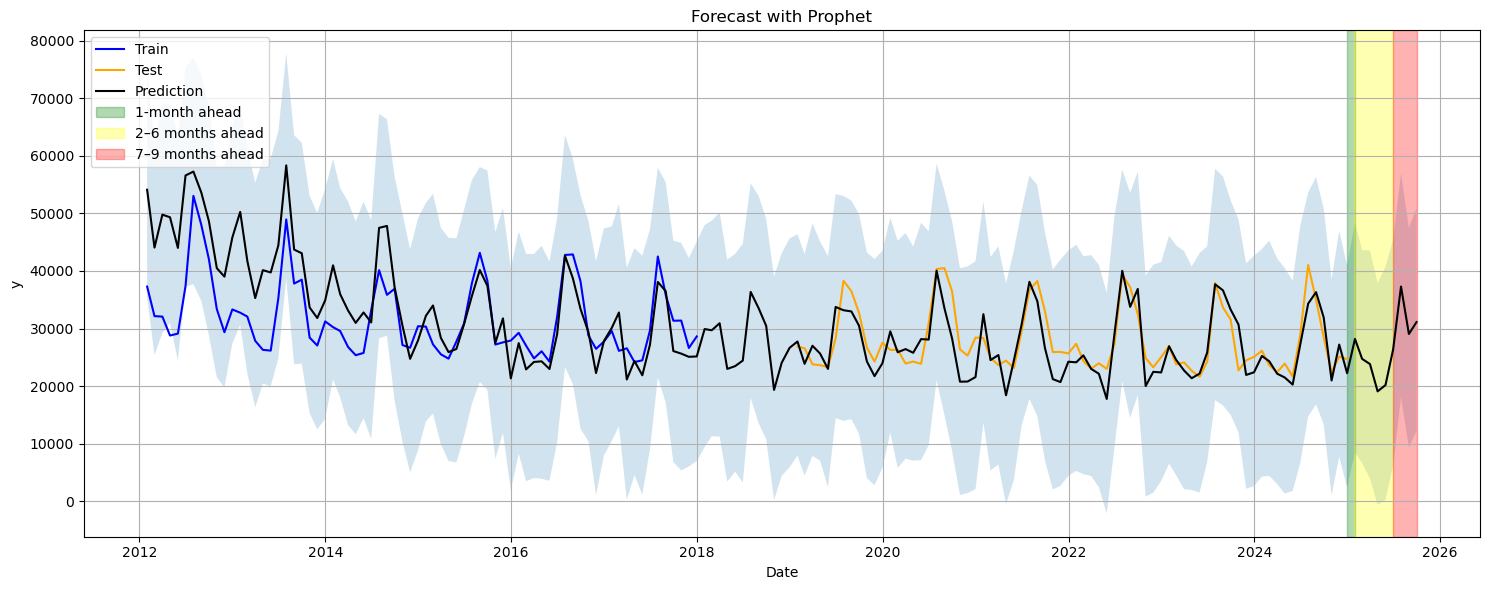

Best Model Evaluations:
MAE: 1620.7402767555163
MAPE: 0.05839846872202643
R^2: 0.8537299995529839

The best parameters are:
growth: linear
n_changepoints: 10
changepoint_prior_scale: 0.1
period: 12
fourier_order: 5


In [71]:
logging.getLogger("cmdstanpy").setLevel(logging.WARNING) # silence training info
df_monthly = df_monthly.reset_index()
results_df, model, forecast = run_pipeline(df_monthly)

#### Yearly
Paramters Grid:\
{\
&nbsp;&nbsp;&nbsp;&nbsp;`growth_options = ['linear', 'logistic', 'flat']`\
&nbsp;&nbsp;&nbsp;&nbsp;`n_changepoints_options = [1, 3, 5]`\
&nbsp;&nbsp;&nbsp;&nbsp;`changepoint_prior_scale_options = [0.05, 0.01, 0.025, 0.075, 0.1]`\
&nbsp;&nbsp;&nbsp;&nbsp;`seasonality_periods : [None, 1, 2]`\
&nbsp;&nbsp;&nbsp;&nbsp;`seasonality_orders' : [2, 4, 10]`\
}

Tuning Monthly Prophet: 100%|██████████| 324/324 [01:04<00:00,  4.99it/s]


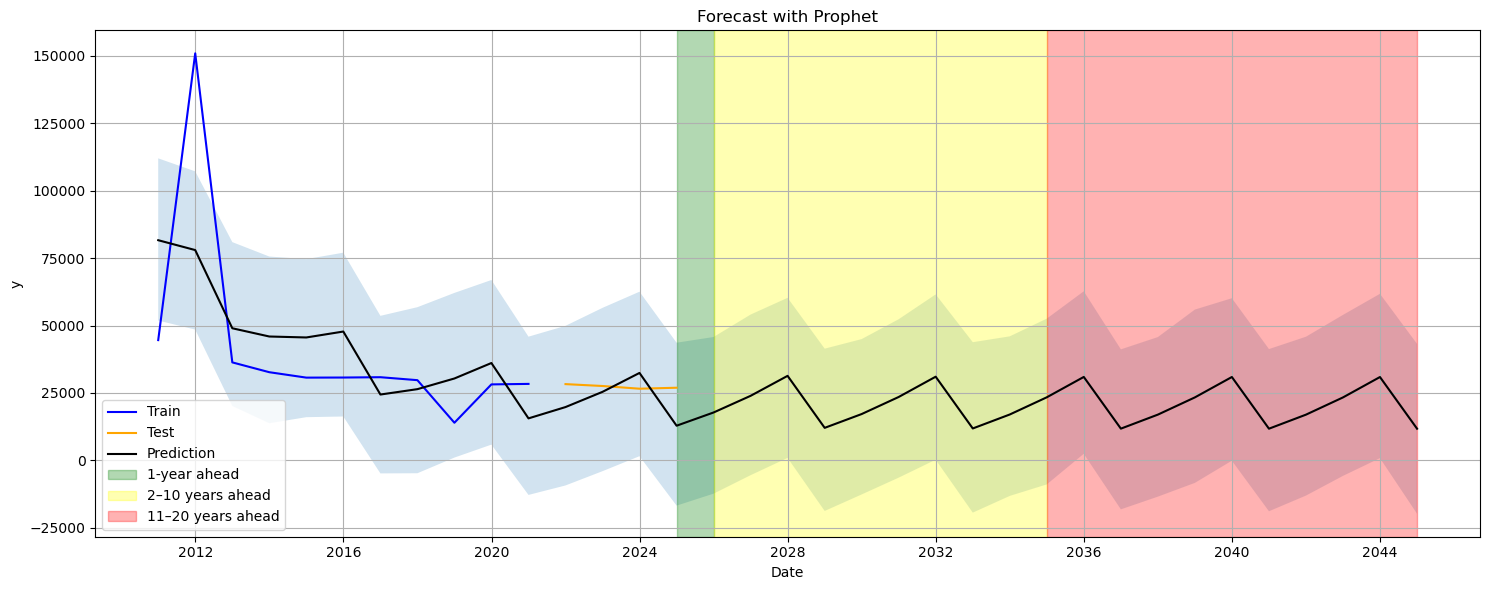

Best Model Evaluations:
MAE: 11548.033875527079
MAPE: 0.4212382997890636
R^2: -462.93899023718416

The best parameters are:
growth: logistic
n_changepoints: 3
changepoint_prior_scale: 0.01
period: 1
fourier_order: 2


In [73]:
logging.getLogger("cmdstanpy").setLevel(logging.WARNING) # silence training info
df_yearly = df_yearly.reset_index()
results_df, model, forecast = run_pipeline(df_yearly)